In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import stim
import pymatching

# 配置表面码参数
code_distances = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
rounds = 250
shots = 100_000  # 可根据计算资源调整

In [3]:
# 创建基于论文参数的噪声模型
def create_noisy_circuit(d: int) -> stim.Circuit:
    return stim.Circuit.generated(
        code_task="surface_code:rotated_memory_z",
        rounds=rounds,
        distance=d,
        # 直接在生成时配置噪声参数
        after_clifford_depolarization=0.001,  # 单量子比特门退极化
        after_reset_flip_probability=0.002,   # 重置/空闲错误
        before_measure_flip_probability=0.004, # 测量错误
        before_round_data_depolarization=0.0028 # 双量子比特门错误
    )

# 运行表面码模拟
def run_surface_code_simulation(d: int):
    noisy_circuit = create_noisy_circuit(d)
    sampler = noisy_circuit.compile_detector_sampler()
    return sampler.sample(shots=shots, separate_observables=True)

# 收集逻辑错误数据
epsilon_d = []
p_det = []

for d in code_distances:
    print(f"正在模拟 distance={d}...")
    detection_events, observable_flips = run_surface_code_simulation(d)
    
    # 使用pymatching解码
    model = create_noisy_circuit(d).detector_error_model()
    matching = pymatching.Matching.from_detector_error_model(model)
    logical_errors = 0
    
    # 批处理解码优化
    predictions = matching.decode_batch(detection_events)
    logical_errors = np.sum(observable_flips ^ predictions)
    
    epsilon_d.append(logical_errors / shots)
    p_det.append(np.sum(detection_events) / (shots * detection_events.shape[1]))
    
epsilon_d = np.array(epsilon_d)
p_det = np.array(p_det)

正在模拟 distance=3...
正在模拟 distance=5...
正在模拟 distance=7...
正在模拟 distance=9...
正在模拟 distance=11...
正在模拟 distance=13...
正在模拟 distance=15...
正在模拟 distance=17...
正在模拟 distance=19...
正在模拟 distance=21...


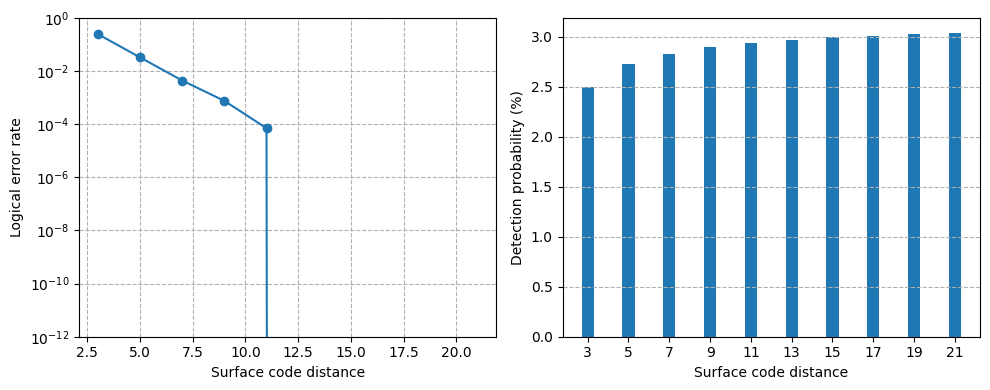

In [4]:
# 可视化部分
plt.figure(figsize=(10, 4))

# 绘制逻辑错误率
plt.subplot(121)
plt.semilogy(code_distances, epsilon_d, 'o-', label='模拟结果')
plt.xlabel("Surface code distance")
plt.ylabel("Logical error rate")
plt.ylim(top=1e0)  # 调整Y轴上限
plt.ylim(bottom=1e-12)  # 调整Y轴下限
plt.grid(True, which='both', linestyle='--')

# 绘制检测概率
plt.subplot(122)
plt.bar(code_distances, p_det*100, width=0.6)
plt.xlabel("Surface code distance")
plt.ylabel("Detection probability (%)")
plt.xticks(code_distances)
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

拟合参数 Λ = 1.0075 ± 0.0010


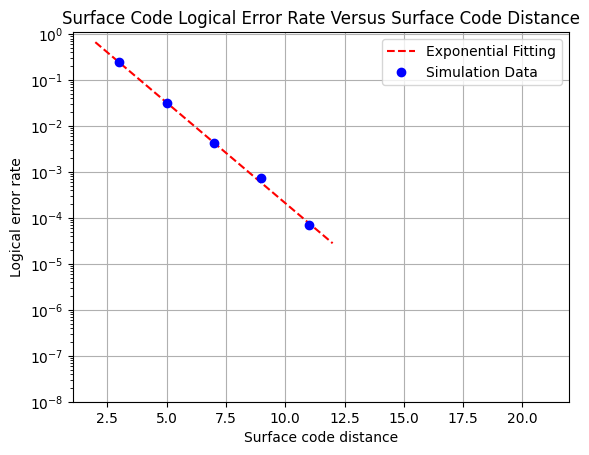

In [5]:
# Λ参数拟合
def lambda_fit(d, Lambda, A):
    exponent = np.clip(-Lambda * d, -100, None)  # 限制指数范围
    return A * np.exp(exponent)

try:
    # 设置合理的初始猜测和参数范围
    popt, pcov = curve_fit(
        lambda_fit, 
        code_distances, 
        epsilon_d, 
        p0=[0.7, 1.5],
        bounds=([0.1, 0.1], [2.0, 10.0])  # 限制 Lambda ∈ [0.1, 10]，A ∈ [1e-5, 1]
    )
    print(f"拟合参数 Λ = {popt[0]:.4f} ± {np.sqrt(pcov[0,0]):.4f}")

except RuntimeError as e:
    print("拟合失败，请检查数据或调整参数范围:", e)

# 绘制拟合曲线
d_fit = np.linspace(2, 12, 100)
plt.semilogy(d_fit, lambda_fit(d_fit, *popt), 'r--', label='Exponential Fitting')
plt.semilogy(code_distances, epsilon_d, 'bo', label='Simulation Data')
plt.title("Surface Code Logical Error Rate Versus Surface Code Distance")
plt.xlabel("Surface code distance")
plt.ylabel("Logical error rate")
plt.ylim(bottom=1e-8)  # 调整Y轴下限
plt.legend()
plt.grid(True)
plt.show()